In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, MaxPooling1D, BatchNormalization, Input, Activation, Add, GlobalAveragePooling1D
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.regularizers import l2

%matplotlib inline

In [23]:
# from google.colab import drive
# drive.mount("/content/drive")
# %cd  /content/drive/MyDrive
# %cd  /content/drive/MyDrive/Colab Notebooks
# %pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/Colab Notebooks


'/content/drive/MyDrive/Colab Notebooks'

# **Loading data and data information - Localization data**
---

In [24]:
# Load the data
X_train = np.load("data/localization/reduced_train/X_train.npy")
Y_train = np.load("data/localization/reduced_train/y_train.npy")
mask_train = np.load("data/localization/reduced_train/mask_train.npy")
X_val =  np.load("data/localization/reduced_val/X_val.npy")
Y_val =  np.load("data/localization/reduced_val/y_val.npy")
mask_val = np.load("data/localization/reduced_val/mask_val.npy")

# Check the shapes of the datasets
print("X_train shape:", X_train.shape)
print("\nY_train shape:", Y_train.shape)
print("\nmask_train shape:", mask_train.shape)
print("-------------------------------")
print("\nX_val shape:", X_val.shape)
print("\nY_val shape:", Y_val.shape)
print("\nmask_val shape:", mask_val.shape)
print("\n-------------------------------")

# Check the type of data
print("\nX_train dtype:", X_train.dtype)
print("\nY_train dtype:", Y_train.dtype)
print("\nmask_train dtype:", mask_train.dtype)
print("\n-------------------------------")

# View a sample from the data
print("\nX_train sample:", X_train[0])
print("\nY_train sample:", Y_train[0])
print("\nmask_train sample:", mask_train[0])
print("\n-------------------------------")


X_train shape: (2423, 400, 20)

Y_train shape: (2423,)

mask_train shape: (2423, 400)
-------------------------------

X_val shape: (635, 400, 20)

Y_val shape: (635,)

mask_val shape: (635, 400)

-------------------------------

X_train dtype: float32

Y_train dtype: int32

mask_train dtype: float32

-------------------------------

X_train sample: [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Y_train sample: 6

mask_train sample: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

In [25]:
# This tells us which data to normalize
print(f"Train images min: {X_train.min()}, max: {X_train.max()}")
print(f"Test images min: {X_val.min()}, max: {X_val.max()}")

Train images min: 0.0, max: 1.0
Test images min: 0.0, max: 1.0



Class distribution in Y_train:
Class 0 (Nucleus): 338 samples
Class 1 (Cytoplasm): 567 samples
Class 2 (Extracellular): 535 samples
Class 3 (Mitochondrion): 233 samples
Class 4 (Cell membrane): 285 samples
Class 5 (ER): 63 samples
Class 6 (Chloroplast): 224 samples
Class 7 (Golgi apparatus): 59 samples
Class 8 (Lysosome): 60 samples
Class 9 (Vacuole): 59 samples


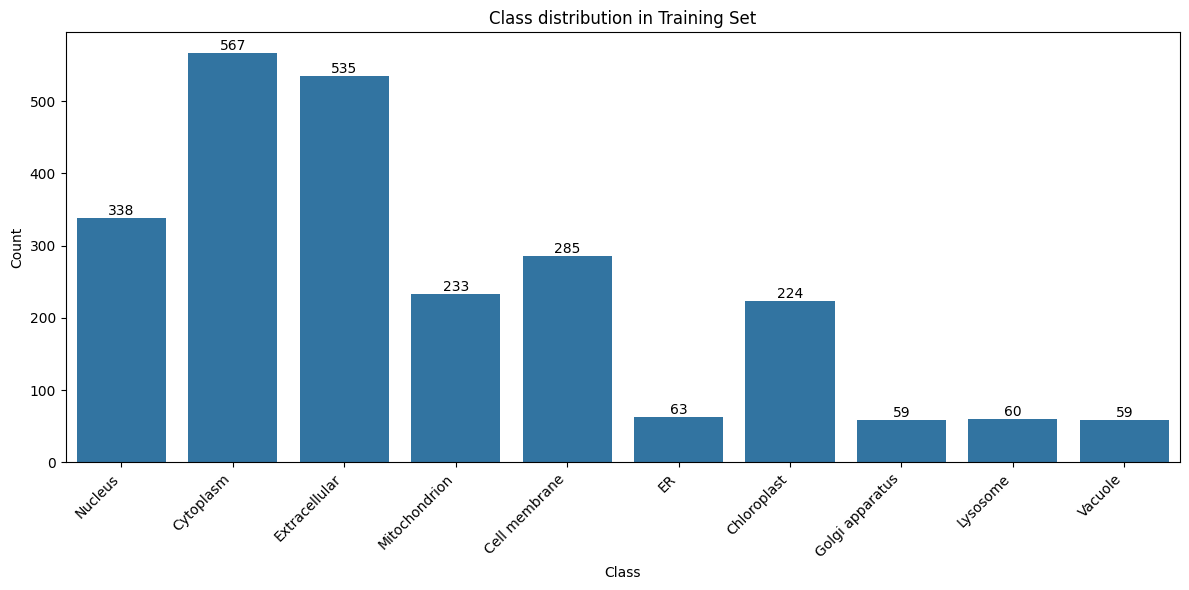

In [26]:
classes = ['Nucleus','Cytoplasm','Extracellular','Mitochondrion','Cell membrane','ER',
           'Chloroplast','Golgi apparatus','Lysosome','Vacuole']

# Class Distribution
unique, counts = np.unique(Y_train, return_counts=True)
print("\nClass distribution in Y_train:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({classes[u]}): {c} samples")

# Plot Class Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=Y_train)
plt.title("Class distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.tight_layout()
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

We can see that the data distribution is imbalanced so we'll need to keep that in mind when we do our model training and when we will want to optimize our models.

# **Data preprocessing**
---

In [27]:
# Label Encoding and One-Hot Encoding of Labels
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(Y_train)
onehot_Y_train = to_categorical(integer_encoded_train)

integer_encoded_val = label_encoder.transform(Y_val)
onehot_Y_val = to_categorical(integer_encoded_val)

# Check the shape of the one-hot encoded labels
print("One-hot encoded Y_train shape:", onehot_Y_train.shape)
print("One-hot encoded Y_val shape:", onehot_Y_val.shape)

One-hot encoded Y_train shape: (2423, 10)
One-hot encoded Y_val shape: (635, 10)


# **1st Model : CNN**
---

## **Version A**

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (400, 20)
num_classes = onehot_Y_train.shape[1]  # Number of output classes

# Model creation
model = keras.Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", padding='same', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation="softmax"))

# Model compilation
batch_size = 128
epochs = 80
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])

# Model training
history = model.fit(X_train, onehot_Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.2630 - loss: 2.0503 - val_accuracy: 0.3588 - val_loss: 1.8501
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.4398 - loss: 1.6699 - val_accuracy: 0.4763 - val_loss: 1.6605
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5483 - loss: 1.3284 - val_accuracy: 0.6021 - val_loss: 1.3622
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.6961 - loss: 0.9891 - val_accuracy: 0.6763 - val_loss: 1.1897
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.7730 - loss: 0.7795 - val_accuracy: 0.6577 - val_loss: 1.0967
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.8010 - loss: 0.6240 - val_accuracy: 0.6969 - val_loss: 0.9804
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8323 - loss: 0.5545 - val_accuracy: 0.7216 - val_loss: 0.9219
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.8762 - loss: 0.4203 - val_accuracy: 0.

In [32]:
def plot_history(history, model_name='Model'):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f'Train accuracy ({model_name})')
    plt.plot(history.history['val_accuracy'], label=f'Val accuracy ({model_name})')
    plt.title(f'{model_name} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'Train loss ({model_name})')
    plt.plot(history.history['val_loss'], label=f'Val loss ({model_name})')
    plt.title(f'{model_name} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.show()

In [33]:
def evaluate_model(model, X_test, Y_test, model_name='Model'):
    """
    This function evaluates the given model using the test data and prints the accuracy and loss.

    Parameters:
    - model: Trained model to be evaluated.
    - X_test: Test features.
    - Y_test: Ground truth labels.

    Returns:
    - evaluation: The result of the model's evaluation (loss and accuracy).
    """

    # Evaluate the model using the test data
    evaluation = model.evaluate(X_test, Y_test)

    # Print accuracy and loss
    print(f"\nModel evaluation {model_name}")
    print("-" * 30)
    print(f"Test Loss:      {evaluation[0]:.6f}")
    print(f"Test Accuracy:  {evaluation[1] * 100:.2f}%")
    print("-" * 30)

In [34]:
def plot_confusion_matrix(model, X_test, Y_test, model_name='Model'):
    """
    This function generates predictions from a model on the test set,
    processes the results, and plots the confusion matrix.

    Parameters:
    - model: Trained model used for prediction.
    - X_test: Test features (can be flattened or raw as per model input).
    - Y_test: Ground truth labels, can be one-hot encoded or class labels.

    Returns:
    - None (Displays the confusion matrix plot).
    """

    # Step 1: Generate predictions on the test set
    Y_pred = model.predict(X_test)

    # Step 2: Convert predicted probabilities to class labels
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    # Step 3: Check if Y_test is one-hot encoded or not
    if len(Y_test.shape) > 1 and Y_test.shape[1] > 1:
        # Case 1: Y_test is one-hot encoded
        Y_true = np.argmax(Y_test, axis=1)
    else:
        # Case 2: Y_test is already in class labels
        Y_true = Y_test

    # Step 4: Compute the confusion matrix
    conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

    # Step 5: Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7780 - loss: 1.1490

Model evaluation CNN Version A
------------------------------
Test Loss:      1.227356
Test Accuracy:  77.95%
------------------------------


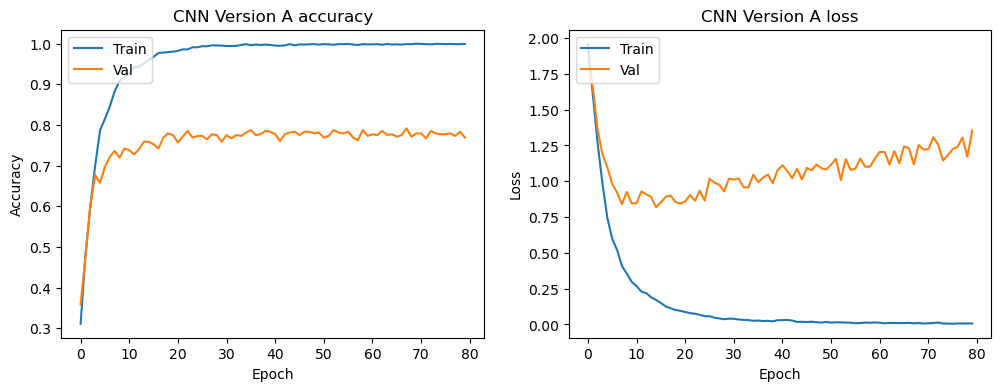

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


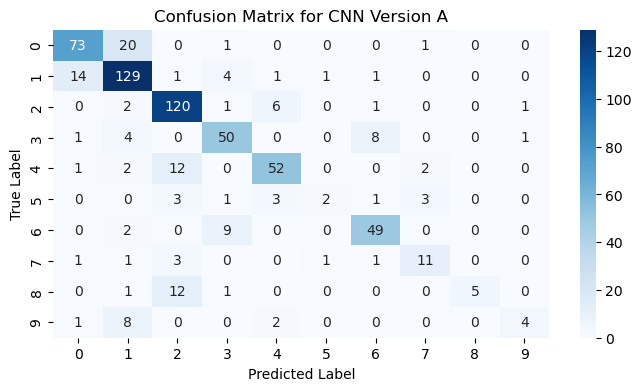

In [ ]:
evaluate_model(model, X_val, onehot_Y_val, 'CNN Version A')
plot_history(history, 'CNN Version A')
plot_confusion_matrix(model, X_val, onehot_Y_val, 'CNN Version A')

We can see that the training of the dataset is good but the validation is not satisfactory : overfitting ? Complex data ?
It's due to a bit of both.

We can especially see thanks to the confusion matrix that the model has trouble predicting the less-represented targets of the dataset. This is due to the unbalanced nature of the data distribution.

## **Version B**


For this more optimized version we will add :
- Class weights (punishes the model harsher for less-represnted targets)
- L2 Regularization
- Increased Dropouts
- Smaller learning rate
- EarlyStopping
- ReduceLROnPlateau

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define input shape and number of output classes
input_shape = (X_train.shape[1], X_train.shape[2])  # (400, 20)
num_classes = onehot_Y_train.shape[1]  # Number of output classes

# Create the CNN model
model = Sequential()

# First Conv Layer with L2 Regularization and Batch Normalization
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", padding='same', input_shape=input_shape, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Second Conv Layer with L2 Regularization and Batch Normalization
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Third Conv Layer with L2 Regularization and Batch Normalization
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Dropout for regularization (Increased Dropout Rate)
model.add(Dropout(0.5))

# Flatten the output for the Dense layers
model.add(Flatten())

# Dense Layer with L2 Regularization
model.add(Dense(units=1024, activation='relu', kernel_regularizer=l2(1e-4)))

# Dropout for regularization (Increased Dropout Rate)
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(num_classes, activation="softmax"))


# Compile the model with a higher learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


# Compute class weights using sklearn
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(onehot_Y_train, axis=1)), y=np.argmax(onehot_Y_train, axis=1))
class_weight_dict = dict(enumerate(class_weights))

# Define callbacks for learning rate scheduling and early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


# Train the model with class weights
history = model.fit(X_train, onehot_Y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, onehot_Y_val),
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, lr_scheduler])


/home/etudiant/.conda/envs/aiao/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.2808 - loss: 5.2645 - val_accuracy: 0.0283 - val_loss: 10.5118 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.6976 - loss: 1.1274 - val_accuracy: 0.0283 - val_loss: 15.4822 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.8266 - loss: 0.6706 - val_accuracy: 0.0283 - val_loss: 15.7289 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.8799 - loss: 0.5377 - val_accuracy: 0.0425 - val_loss: 11.7791 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9211 - loss: 0.4096 - val_accuracy: 0.0992 - val_loss: 7.9020 - learning_rate: 5.0000e-04
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9388 - loss: 0.3977 - val_accuracy: 0.3937 - val_loss: 3.4347 - learning_rate: 5.0000e-04
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9640 -

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8004 - loss: 1.0082

Model evaluation CNN Version B
------------------------------
Test Loss:      0.963140
Test Accuracy:  81.73%
------------------------------


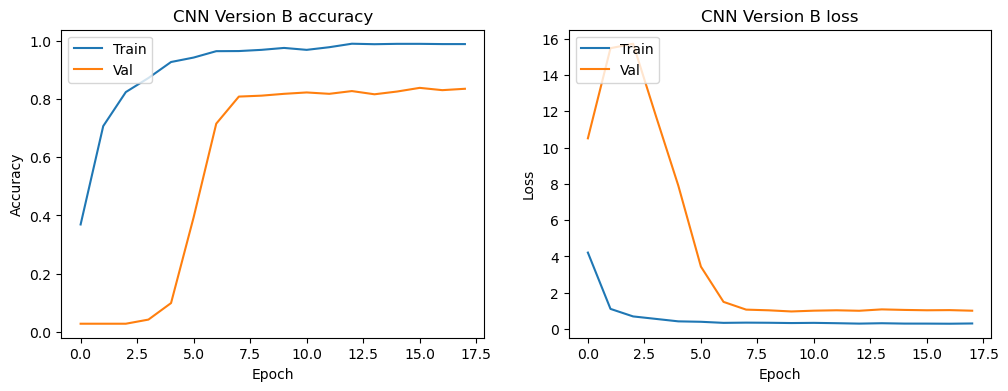

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


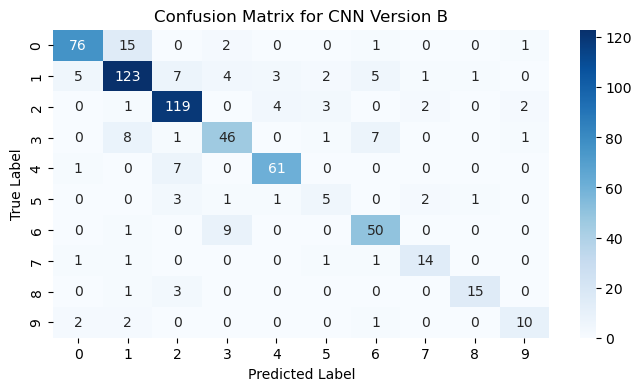

In [ ]:
evaluate_model(model, X_val, onehot_Y_val, 'CNN Version B')
plot_history(history, 'CNN Version B')
plot_confusion_matrix(model, X_val, onehot_Y_val, 'CNN Version B')

We can see that with the class weights, the less-represented targets get predicted a bit more but it's still not there yet.

The performance of the CCN Version B model is still better than Version A though.

# **2nd Model : ResNet**
---

## **Version A**

In [29]:
import tensorflow as tf
from keras.layers import Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense, Input, Dropout
from keras.models import Model
from keras.regularizers import l2

# Residual Block with L2 Regularization
def residual_block(x, filters, kernel_size, stride=1, reg=l2(1e-4)):
    shortcut = x  # Shortcut connection to add later

    # First convolution
    x = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution
    x = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)

    # Add the shortcut connection to the output (Residual connection)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Create Simple ResNet Model
def create_resnet_model(input_shape, num_classes, num_blocks=3, filters=64, kernel_size=3):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Stack Residual Blocks
    for _ in range(num_blocks):
        x = residual_block(x, filters=filters, kernel_size=kernel_size)

    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)

    # Dense Layer for Classification
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2])  # (400, 20)
num_classes = onehot_Y_train.shape[1]  # Number of output classes

# Create the ResNet model without class weights
resnet_model = create_resnet_model(input_shape, num_classes)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for learning rate scheduling and early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the ResNet model
history = resnet_model.fit(X_train, onehot_Y_train,
                           batch_size=32,
                           epochs=50,
                           validation_data=(X_val, onehot_Y_val),
                           callbacks=[early_stopping, lr_scheduler])


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 361ms/step - accuracy: 0.1339 - loss: 2.5499 - val_accuracy: 0.1496 - val_loss: 2.2603 - learning_rate: 1.0000e-04
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 38s 321ms/step - accuracy: 0.2874 - loss: 2.0591 - val_accuracy: 0.1496 - val_loss: 2.2345 - learning_rate: 1.0000e-04
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - accuracy: 0.3956 - loss: 1.8626 - val_accuracy: 0.1496 - val_loss: 2.3378 - learning_rate: 1.0000e-04
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 324ms/step - accuracy: 0.4707 - loss: 1.6973 - val_accuracy: 0.1496 - val_loss: 2.3940 - learning_rate: 1.0000e-04
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 43s 359ms/step - accuracy: 0.5094 - loss: 1.5859 - val_accuracy: 0.1543 - val_loss: 2.2504 - learning_rate: 1.0000e-04
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 305ms/step - accuracy: 0.5500 - loss: 1.4694 - val_accuracy: 0.2772 - val_loss: 1.8723 - learning_rate: 5.0000e-05
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 40s 291ms/step - acc

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7840 - loss: 0.7351

Model evaluation ResNet Version A
------------------------------
Test Loss:      0.715768
Test Accuracy:  79.84%
------------------------------


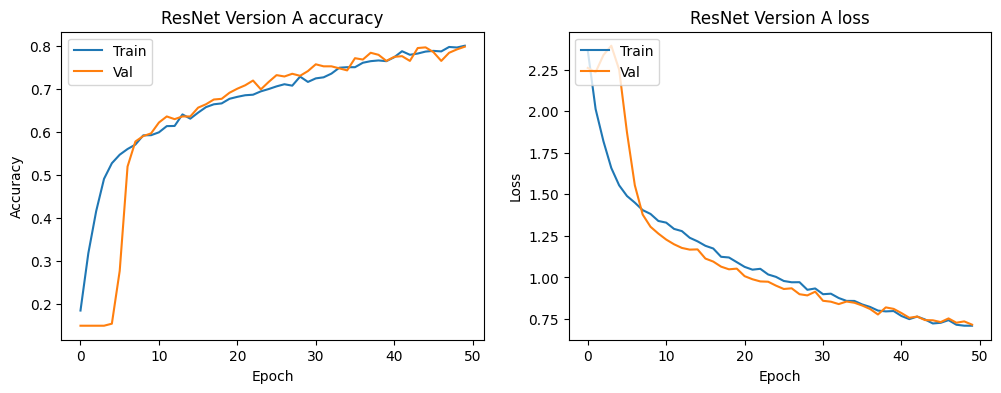

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


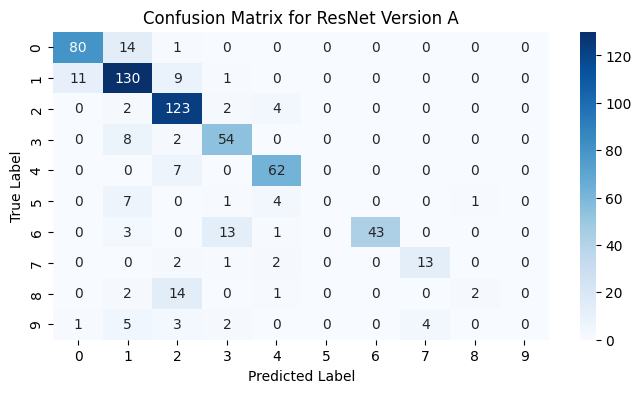

In [35]:
evaluate_model(resnet_model, X_val, onehot_Y_val, 'ResNet Version A')
plot_history(history, 'ResNet Version A')
plot_confusion_matrix(resnet_model, X_val, onehot_Y_val, 'ResNet Version A')

## **Version B**

Now we try adding the class weights.

In [36]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Create the ResNet model
resnet_model_with_weights = create_resnet_model(input_shape, num_classes)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Learning rate can be adjusted
resnet_model_with_weights.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Compute class weights using sklearn
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(onehot_Y_train, axis=1)), y=np.argmax(onehot_Y_train, axis=1))
class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
history_resnet_with_weights = resnet_model_with_weights.fit(X_train, onehot_Y_train,
                    batch_size=68,
                    epochs=50,
                    validation_data=(X_val, onehot_Y_val),
                    class_weight=class_weight_dict)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 841ms/step - accuracy: 0.1094 - loss: 2.7026 - val_accuracy: 0.1937 - val_loss: 2.3534
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 674ms/step - accuracy: 0.1328 - loss: 2.4458 - val_accuracy: 0.2063 - val_loss: 2.3442
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 43s 724ms/step - accuracy: 0.1406 - loss: 2.3750 - val_accuracy: 0.1969 - val_loss: 2.3294
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 763ms/step - accuracy: 0.1520 - loss: 2.2627 - val_accuracy: 0.1953 - val_loss: 2.3182
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 725ms/step - accuracy: 0.2217 - loss: 2.1687 - val_accuracy: 0.0945 - val_loss: 2.3179
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 668ms/step - accuracy: 0.2538 - loss: 2.1056 - val_accuracy: 0.0992 - val_loss: 2.3187
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 665ms/step - accuracy: 0.2677 - loss: 2.1069 - val_accuracy: 0.1008 - val_loss: 2.3115
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 648ms/step - accuracy: 0.3330 - loss: 1.9366 - val_accu

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7779 - loss: 0.7933

Model evaluation ResNet Version B
------------------------------
Test Loss:      0.762962
Test Accuracy:  79.84%
------------------------------


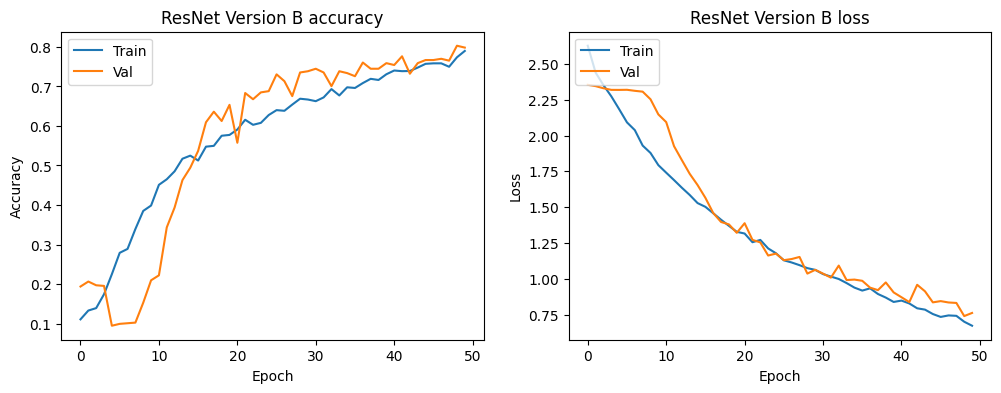

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


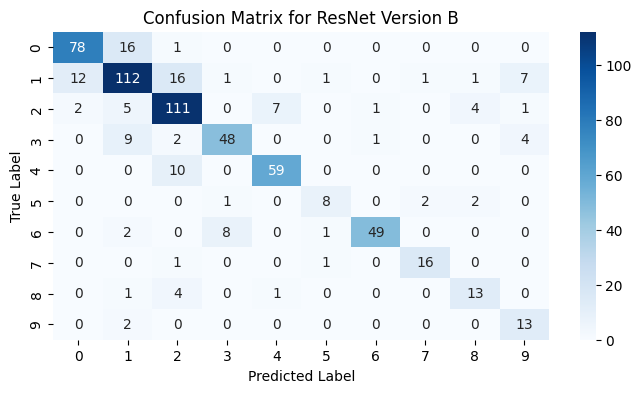

In [37]:
evaluate_model(resnet_model_with_weights, X_val, onehot_Y_val, 'ResNet Version B')
plot_history(history_resnet_with_weights, 'ResNet Version B')
plot_confusion_matrix(resnet_model_with_weights, X_val, onehot_Y_val, 'ResNet Version B')

Overall performance remains the same. However, we can see that the model predicts more of the the less-represented classes.